In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.metrics import auc

# 1.

In [7]:
# dataset_wine = load_wine()
# wine_df = pd.DataFrame(dataset_wine.data, columns=dataset_wine.feature_names)
# wine_df['class'] = dataset_wine.target
# wine_df.head()

In [27]:
dataset_wine = pd.read_csv('winequality-white.csv', sep=';')
wine_df = dataset_wine
wine_df = wine_df[wine_df['quality'] != 3]
wine_df = wine_df[wine_df['quality'] != 9]
print(wine_df['quality'].unique(), len(wine_df), len(dataset_wine))
print(wine_df['quality'].value_counts())
wine_df.head()
print(f'\nсоотношение max/min по кол-ву: {len(wine_df[wine_df['quality']==6])/len(wine_df[wine_df['quality']==4])}')

[6 5 7 8 4] 4873 4898
quality
6    2198
5    1457
7     880
8     175
4     163
Name: count, dtype: int64

соотношение max/min по кол-ву: 13.484662576687116


In [9]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [ ]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']
# X = wine_df.drop('class', axis=1)
# y = wine_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = CatBoostClassifier(loss_function='MultiClass', iterations=350, random_seed=42, task_type="CPU")
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
# model = SVC(kernel='linear', probability=True, random_state=42)
# model.fit(X_train, y_train)

# 2.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

In [12]:
y_predict = model.predict(X_test)

cm = confusion_matrix(y_test, y_predict)

# Accuracy
accuracy = accuracy_score(y_test, y_predict)

#Precision
precision = precision_score(y_test, y_predict, average='weighted')

#Recall
recall = recall_score(y_test, y_predict, average='weighted')

#Specificity
specificity_per_class = []

for i in range(len(cm)):
    true_negatives = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    false_positives = np.sum(np.delete(cm[:, i], i))
    specificity = true_negatives / (true_negatives + false_positives)
    specificity_per_class.append(specificity)

print(f'Specificity per class: {specificity_per_class}\nAverage Specificity: {np.mean(specificity_per_class):.3f}\n')
print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}\n')
print(f'Conf matrix:\n{cm}')

Specificity per class: [0.9957537154989384, 0.8640350877192983, 0.5981308411214953, 0.9386733416770964, 0.9968085106382979]
Average Specificity: 0.879

Accuracy: 0.627, Precision: 0.635, Recall: 0.627

Conf matrix:
[[  9  16   8   0   0]
 [  2 176 109   4   0]
 [  1  71 331  36   1]
 [  1   5  85  83   2]
 [  0   1  13   9  12]]


# 3, 4. 

## ROC-AUG on test

In [13]:
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[4, 5, 6, 7, 8])
# y_bin = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])
# y_bin = label_binarize(y_test, classes=[0, 1, 2])
y_bin

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

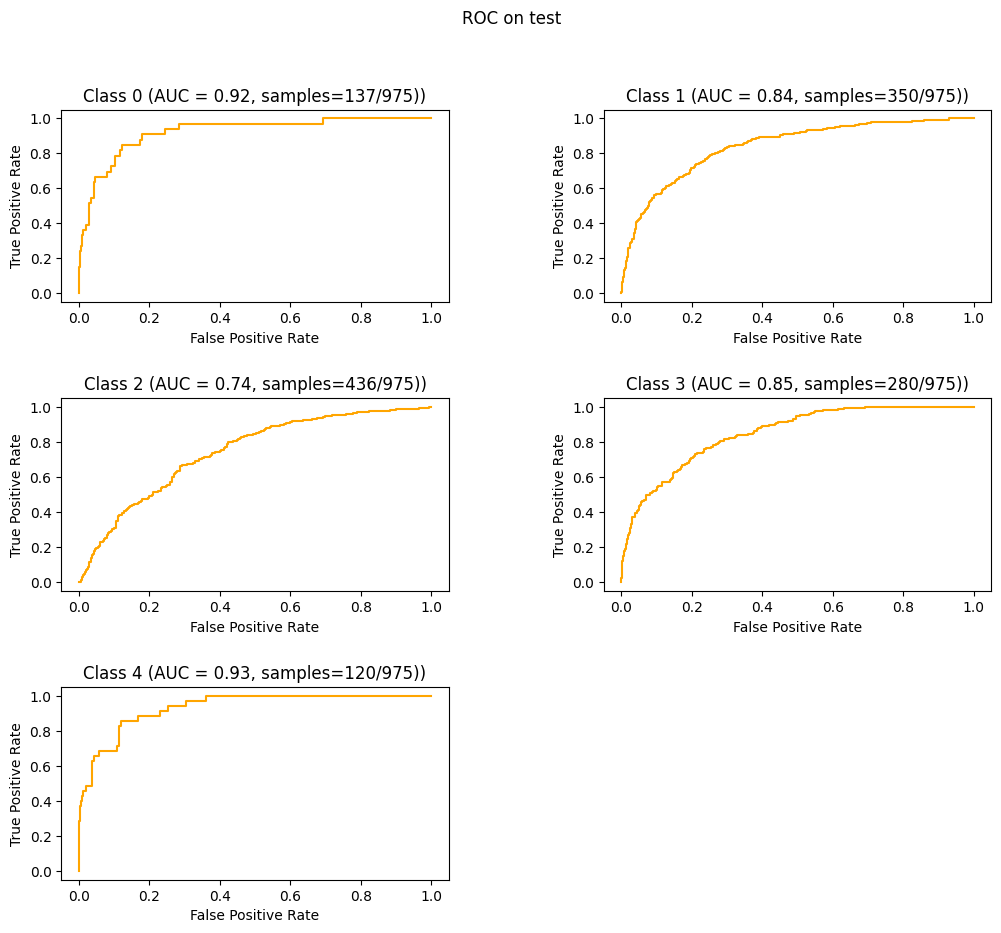

In [14]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_predict_probs = model.predict_proba(X_test)

for i in range(y_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_predict_probs[:, i])
    roc_auc[i] = roc_auc_score(y_bin[:, i], y_predict_probs[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on test')
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr[i], tpr[i], 'orange')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc[i]:.2f}, samples={len(tpr[i])}/{len(X_test)}))')

## ROC-AUG on train

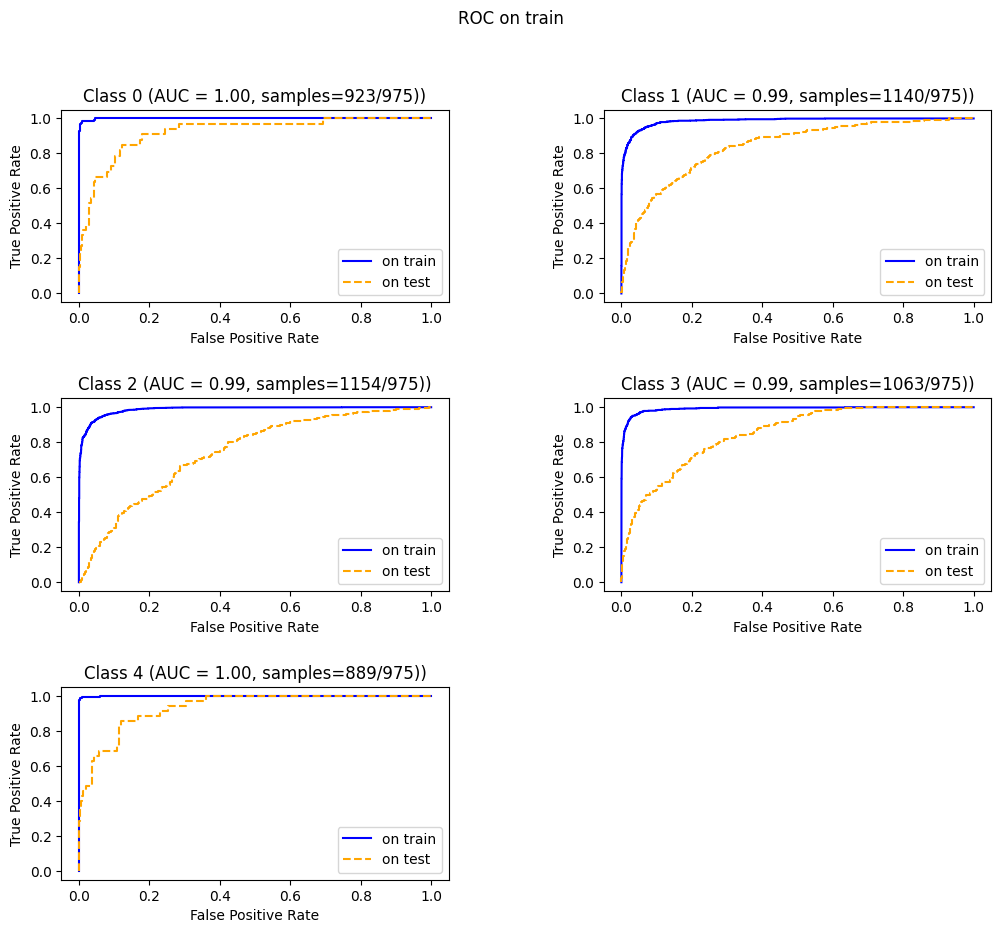

In [15]:
y_bin_train = label_binarize(y_train, classes=[4, 5, 6, 7, 8])
# y_bin = label_binarize(y_train, classes=[0, 1, 2])

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
y_predict_probs_train = model.predict_proba(X_train)

for i in range(y_bin_train.shape[1]):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_bin_train[:, i], y_predict_probs_train[:, i])
    roc_auc_train[i] = roc_auc_score(y_bin_train[:, i], y_predict_probs_train[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on train')
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin_train.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin_train.shape[1] // 2 + 1, y_bin_train.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr_train[i], tpr_train[i], linestyle='-', color='blue', label='on train')
    plt.plot(fpr[i], tpr[i], linestyle='--', color='orange', label='on test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc_train[i]:.2f}, samples={len(tpr_train[i])}/{len(X_test)}))')
    plt.legend()

## ROC-AUG on cross-val

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

Learning rate set to 0.20593
0:	learn: 1.4587963	total: 16.4ms	remaining: 5.71s
1:	learn: 1.3436998	total: 29.1ms	remaining: 5.06s
2:	learn: 1.2719527	total: 42.5ms	remaining: 4.91s
3:	learn: 1.2130227	total: 54.3ms	remaining: 4.7s
4:	learn: 1.1676033	total: 65.7ms	remaining: 4.54s
5:	learn: 1.1353905	total: 76.1ms	remaining: 4.37s
6:	learn: 1.1088102	total: 85.4ms	remaining: 4.19s
7:	learn: 1.0883757	total: 95.4ms	remaining: 4.08s
8:	learn: 1.0693124	total: 106ms	remaining: 4.02s
9:	learn: 1.0548256	total: 115ms	remaining: 3.92s
10:	learn: 1.0415982	total: 125ms	remaining: 3.87s
11:	learn: 1.0307867	total: 134ms	remaining: 3.78s
12:	learn: 1.0180741	total: 143ms	remaining: 3.72s
13:	learn: 1.0064819	total: 153ms	remaining: 3.66s
14:	learn: 0.9956953	total: 162ms	remaining: 3.61s
15:	learn: 0.9873026	total: 171ms	remaining: 3.57s
16:	learn: 0.9800375	total: 180ms	remaining: 3.52s
17:	learn: 0.9704953	total: 190ms	remaining: 3.5s
18:	learn: 0.9641574	total: 199ms	remaining: 3.46s
19:	le

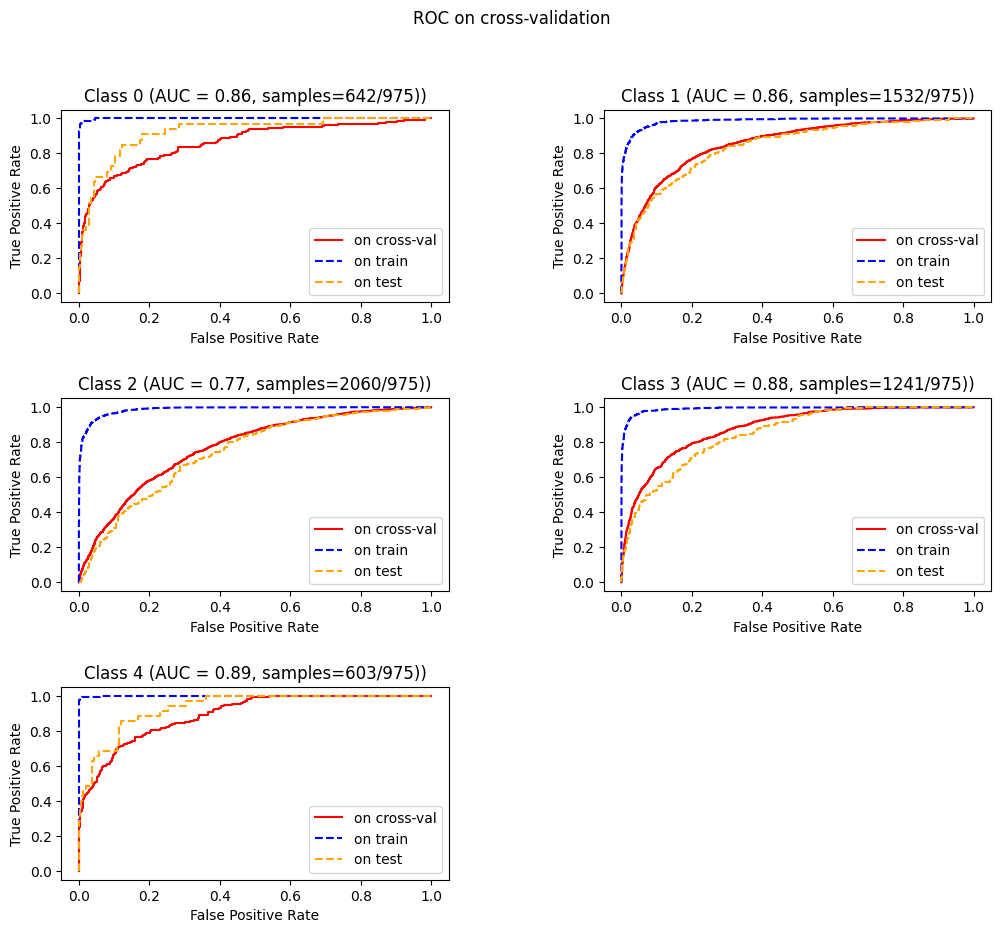

In [17]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']

y_bin_cross_val = label_binarize(y, classes=[4, 5, 6, 7, 8])
# y_bin = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])

model_cross_val = CatBoostClassifier(loss_function='MultiClass', iterations=350, random_seed=42, task_type="CPU")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_predict_probs_cross_val = cross_val_predict(model_cross_val, X, y, cv=cv, method='predict_proba')

fpr_cross_val = dict()
tpr_cross_val = dict()
roc_auc_cross_val = dict()

for i in range(y_bin.shape[1]):
    fpr_cross_val[i], tpr_cross_val[i], _ = roc_curve(y_bin_cross_val[:, i], y_predict_probs_cross_val[:, i])
    roc_auc_cross_val[i] = roc_auc_score(y_bin_cross_val[:, i], y_predict_probs_cross_val[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on cross-validation')
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i in range(y_bin_cross_val.shape[1]):
    plt.subplot(y_bin_cross_val.shape[1] // 2 + 1, y_bin_cross_val.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr_cross_val[i], tpr_cross_val[i], linestyle='-', color='red', label='on cross-val')
    plt.plot(fpr_train[i], tpr_train[i], linestyle='--', color='blue', label='on train')
    plt.plot(fpr[i], tpr[i], linestyle='--', color='orange', label='on test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc_cross_val[i]:.2f}, samples={len(tpr_cross_val[i])}/{len(X_test)}))')
    plt.legend()


## ROC confidence interval

In [18]:
print(len(y_predict_probs_cross_val))
print(len(y))

4873
4873


In [19]:
from scipy.stats import norm

quality
6    2198
5    1457
7     880
8     175
4     163
Name: count, dtype: int64
Learning rate set to 0.207743
0:	learn: 1.4556351	total: 17.4ms	remaining: 6.07s
1:	learn: 1.3424203	total: 38ms	remaining: 6.62s
2:	learn: 1.2732853	total: 58.4ms	remaining: 6.75s
3:	learn: 1.2148457	total: 75.6ms	remaining: 6.54s
4:	learn: 1.1705538	total: 94.1ms	remaining: 6.49s
5:	learn: 1.1412630	total: 107ms	remaining: 6.14s
6:	learn: 1.1158810	total: 122ms	remaining: 5.97s
7:	learn: 1.0898476	total: 135ms	remaining: 5.79s
8:	learn: 1.0714377	total: 149ms	remaining: 5.65s
9:	learn: 1.0579128	total: 163ms	remaining: 5.54s
10:	learn: 1.0436363	total: 177ms	remaining: 5.46s
11:	learn: 1.0312950	total: 193ms	remaining: 5.44s
12:	learn: 1.0193420	total: 209ms	remaining: 5.41s
13:	learn: 1.0087853	total: 221ms	remaining: 5.31s
14:	learn: 1.0033182	total: 234ms	remaining: 5.22s
15:	learn: 0.9952551	total: 248ms	remaining: 5.17s
16:	learn: 0.9855705	total: 261ms	remaining: 5.11s
17:	learn: 0.9792827	total

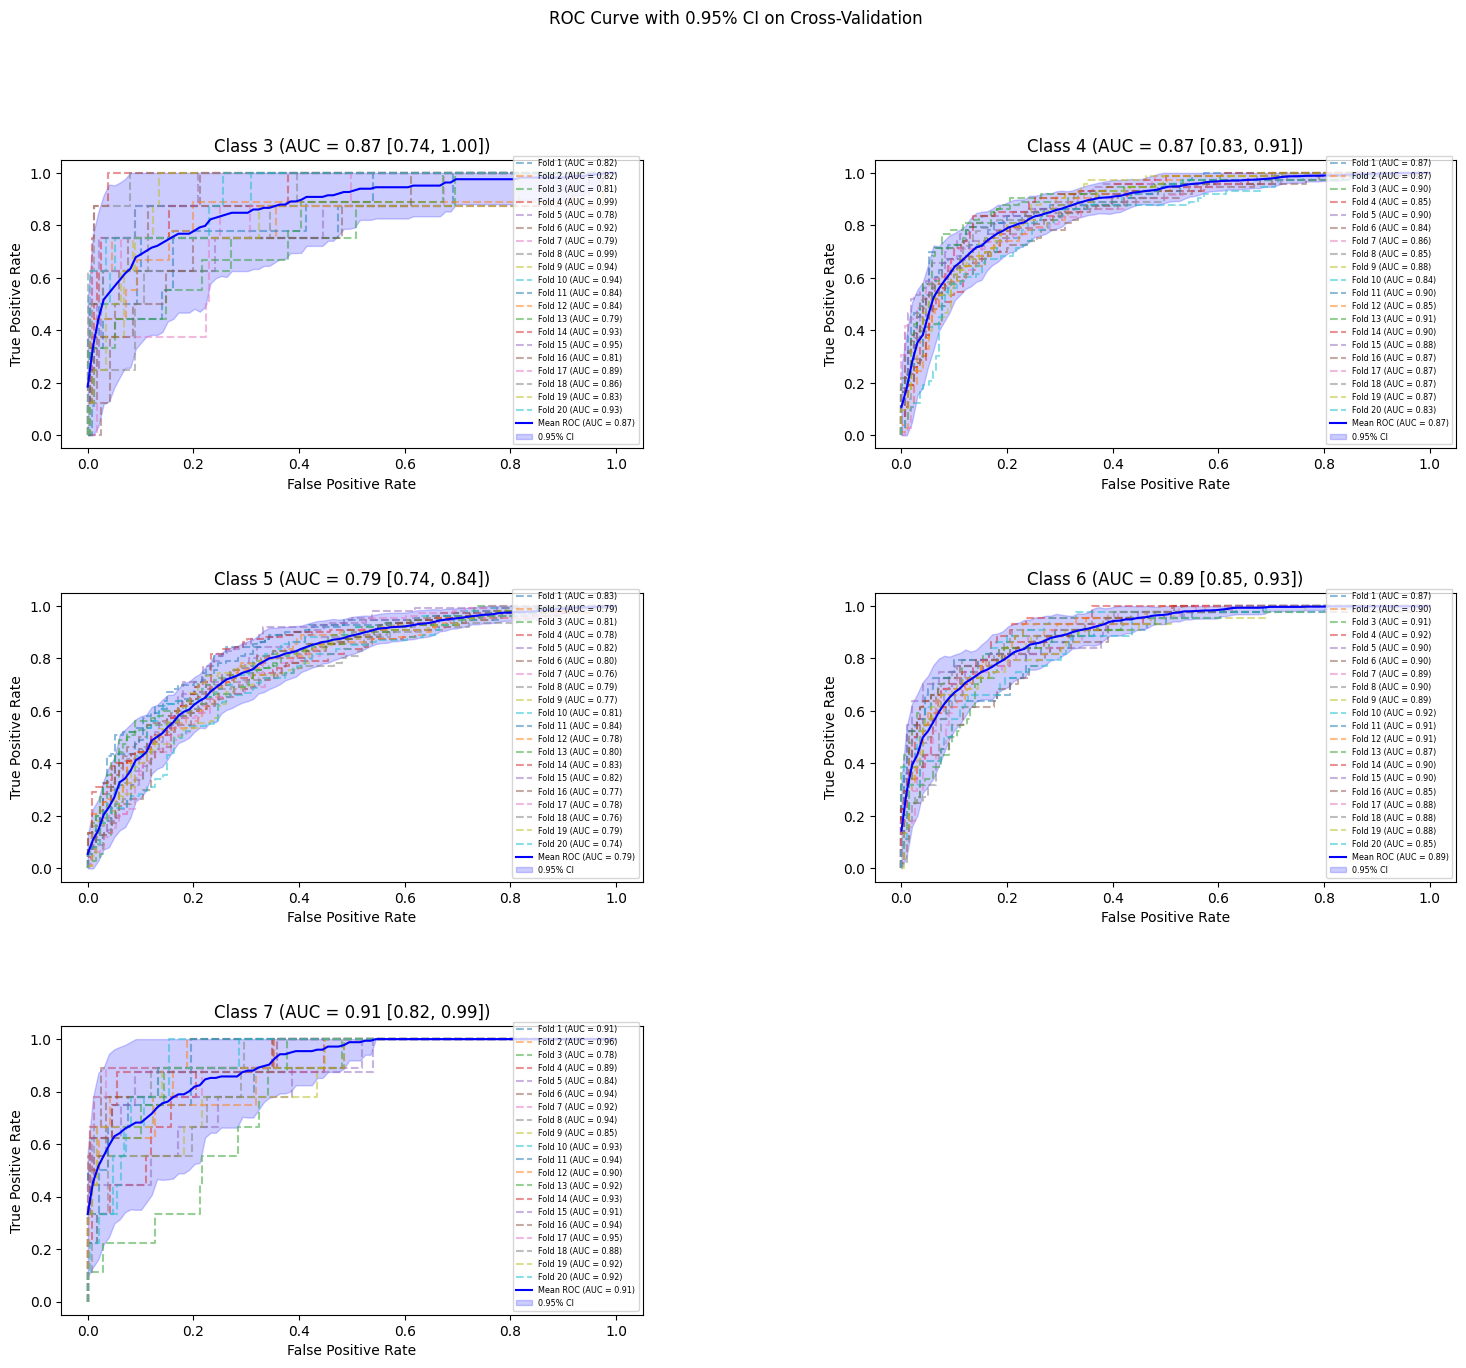

In [37]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']
print(y.value_counts())
y_bin_cross_val = label_binarize(y, classes=[4, 5, 6, 7, 8])
# y_bin = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])

model_cross_val = CatBoostClassifier(loss_function='MultiClass', iterations=350, random_seed=42, task_type="CPU")

cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

tprs = {i: [] for i in range(y_bin_cross_val.shape[1])} # Словарь TPR
aucs = {i: [] for i in range(y_bin_cross_val.shape[1])} # Словарь AUC
mean_fpr = np.linspace(0, 1, 100)

confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2) # Для доверительного

plt.figure(figsize=(18, 15))
plt.suptitle(f'ROC Curve with {confidence_level}% CI on Cross-Validation')
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for fold_idx, (train, test) in enumerate(cv.split(X, y)): # цикл по фолдам
    model_cross_val.fit(X.iloc[train], y.iloc[train])
    y_predict_probs = model_cross_val.predict_proba(X.iloc[test])
    
    for i in range(y_bin_cross_val.shape[1]): # Цикл по классам
        fpr, tpr, _ = roc_curve(y_bin_cross_val[test, i], y_predict_probs[:, i])
        roc_auc = auc(fpr, tpr)
        aucs[i].append(roc_auc)
        
        tpr_interp = np.interp(mean_fpr, fpr, tpr) # Интерполяция, для получения промежуточных точек, кол-во точек = mean_fpr
        tprs[i].append(tpr_interp)
        
        plt.subplot(y_bin_cross_val.shape[1] // 2 + 1, y_bin_cross_val.shape[1] % 2 + 1, i + 1)
        plt.plot(fpr, tpr, linestyle='--', label=f'Fold {fold_idx+1} (AUC = {roc_auc:.2f})', alpha=0.5)

for i in range(y_bin_cross_val.shape[1]): # Цикл по классам
    mean_tpr = np.mean(tprs[i], axis=0)
    mean_auc = np.mean(aucs[i]) # Средние
    std_auc = np.std(aucs[i]) # Стандартное отклонение

    confidence_lower = max(0, mean_auc - z_score * std_auc) # Высчитываем доверительный интервал
    confidence_upper = min(1, mean_auc + z_score * std_auc) #

    tpr_std = np.std(tprs[i], axis=0)

    plt.subplot(y_bin_cross_val.shape[1] // 2 + 1, y_bin_cross_val.shape[1] % 2 + 1, i + 1)
    plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.fill_between(mean_fpr, np.maximum(0, mean_tpr - z_score * tpr_std), np.minimum(1, mean_tpr + z_score * tpr_std), color='b', alpha=0.2, label=f'{confidence_level}% CI')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i+4} (AUC = {mean_auc:.2f} [{confidence_lower:.2f}, {confidence_upper:.2f}])')
    plt.legend(loc="lower right", fontsize='xx-small')

print(y.value_counts())
plt.show()

## Precision-Recall curve

In [29]:
from sklearn.metrics import precision_recall_curve

In [35]:
y_bin

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

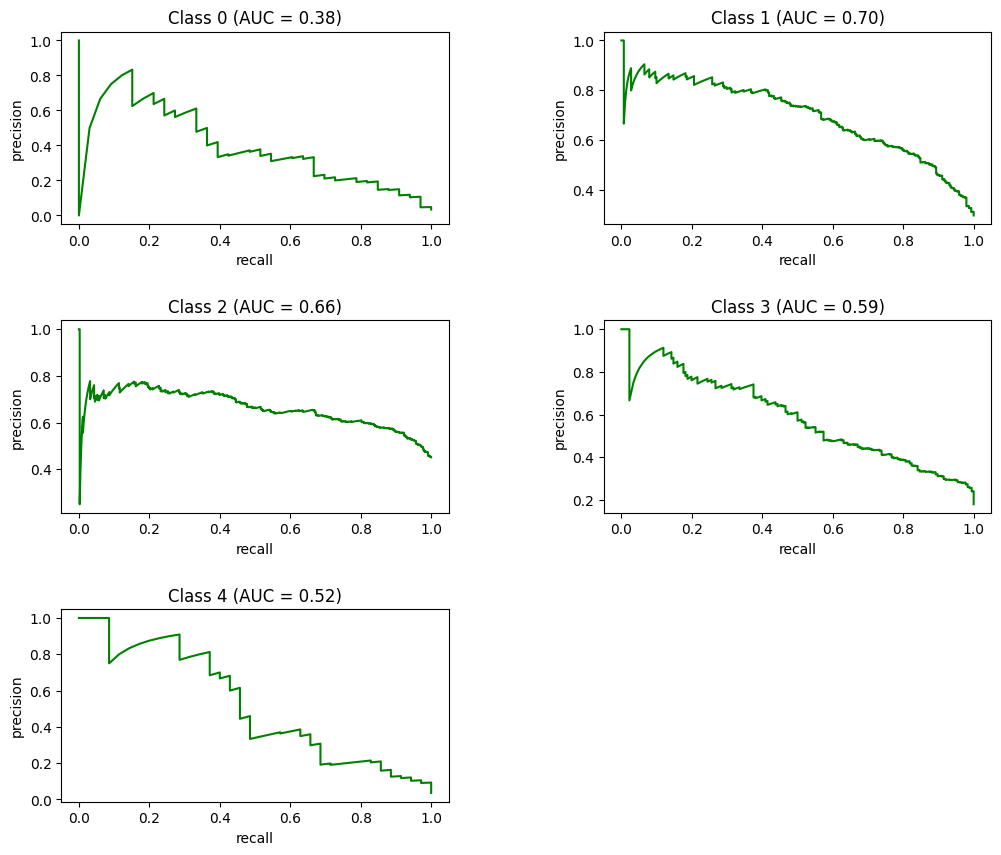

In [34]:
fpr2 = dict()
tpr2 = dict()
pr_auc = dict()
y_predict_probs = model.predict_proba(X_test)

for i in range(y_bin.shape[1]):
    fpr2[i], tpr2[i], _ = precision_recall_curve(y_bin[:, i], y_predict_probs[:, i])
    pr_auc[i] = auc(tpr2[i], fpr2[i])

plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.plot(tpr2[i], fpr2[i], 'green')
    plt.ylabel('precision')
    plt.xlabel('recall')
    plt.title(f'Class {i} (AUC = {pr_auc[i]:.2f})')

# 5.

In [16]:
from sklearn.metrics import log_loss
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [17]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']

# 2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_bin5 = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])

# 3. Обучение моделей
# AdaBoost
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

c:\Users\ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GradientBoostingClassifier(random_state=42)

c:\Users\ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



class 0
AdaBoost - AUC: 0.54, Log Loss: 0.16, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.53, Log Loss: 0.09, Precision: 0.00, Recall: 0.00

class 1
AdaBoost - AUC: 0.51, Log Loss: 0.24, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.80, Log Loss: 0.12, Precision: 0.46, Recall: 0.36

class 2
AdaBoost - AUC: 0.67, Log Loss: 0.66, Precision: 0.41, Recall: 0.88
Gradient Boosting - AUC: 0.80, Log Loss: 0.50, Precision: 0.63, Recall: 0.53

class 3
AdaBoost - AUC: 0.48, Log Loss: 0.90, Precision: 0.47, Recall: 0.38
Gradient Boosting - AUC: 0.68, Log Loss: 0.70, Precision: 0.57, Recall: 0.75

class 4
AdaBoost - AUC: 0.70, Log Loss: 0.47, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.83, Log Loss: 0.36, Precision: 0.56, Recall: 0.34

class 5
AdaBoost - AUC: 0.69, Log Loss: 0.24, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.91, Log Loss: 0.10, Precision: 0.69, Recall: 0.26

class 6
AdaBoost - AUC: 0.93, Log Loss: 0.02, Precision: 0.00, Recall: 0.00

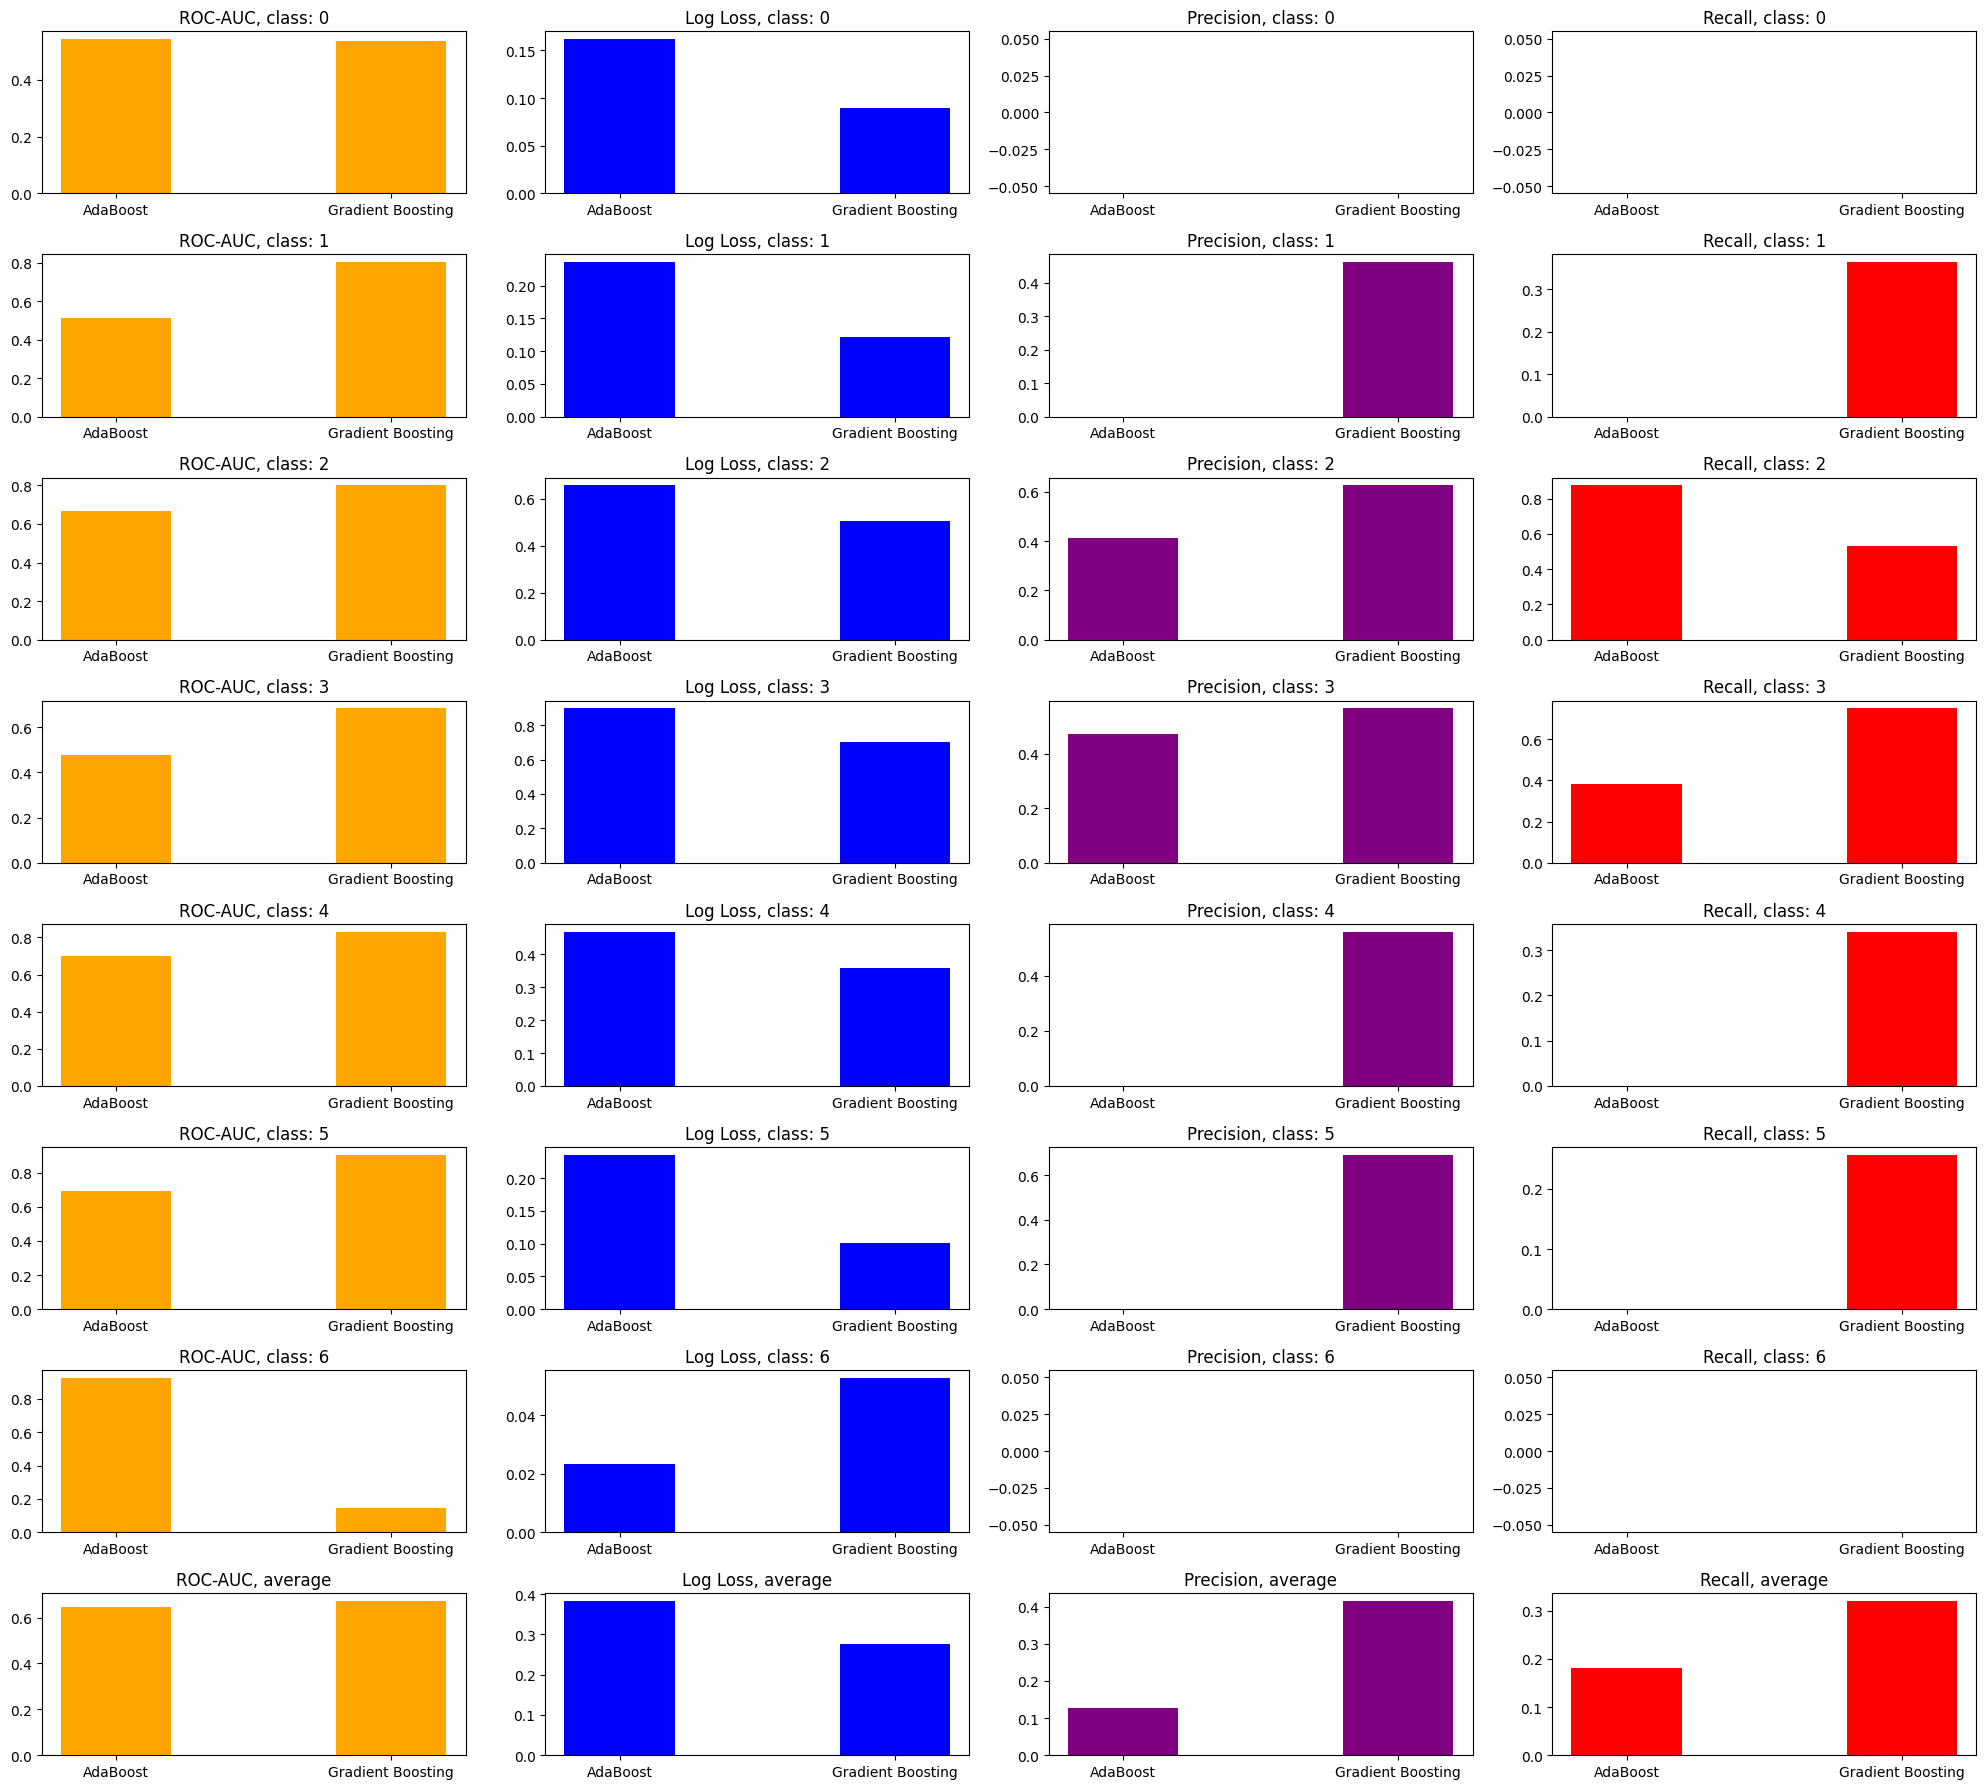

In [18]:
y_pred_ada = ada_model.predict(X_test)
y_pred_proba_ada = ada_model.predict_proba(X_test)

y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

precision_ada = precision_score(y_test, y_pred_ada, average=None)
precision_gb = precision_score(y_test, y_pred_gb, average=None)

recall_ada = recall_score(y_test, y_pred_ada, average=None)
recall_gb = recall_score(y_test, y_pred_gb, average=None)

avg_auc_ada, avg_auc_gb = 0, 0
avg_log_loss_ada, avg_log_loss_gb = 0, 0
avg_precision_ada, avg_precision_gb = 0, 0
avg_recall_ada, avg_recall_gb = 0, 0

num_of_metrics = 4
fig, ax = plt.subplots(y_bin.shape[1] + 1, num_of_metrics, figsize=(20, 18))
for i in range(y_bin.shape[1]):
    roc_auc_ada = roc_auc_score(y_bin5[:, i], y_pred_proba_ada[:, i]) 
    roc_auc_gb = roc_auc_score(y_bin5[:, i], y_pred_proba_gb[:, i])

    log_loss_ada = log_loss(y_bin5[:,i], y_pred_proba_ada[:,i])
    log_loss_gb = log_loss(y_bin5[:,i], y_pred_proba_gb[:,i])
    #log_loss_ada = log_loss(y_test, y_pred_proba_ada)
    #log_loss_gb = log_loss(y_test, y_pred_proba_gb)

    avg_auc_ada += roc_auc_ada
    avg_auc_gb += roc_auc_gb
    avg_log_loss_ada += log_loss_ada
    avg_log_loss_gb += log_loss_gb
    avg_precision_ada += precision_ada[i]
    avg_precision_gb += precision_gb[i]
    avg_recall_ada += recall_ada[i]
    avg_recall_gb += recall_gb[i]

    print(f"\nclass {i}")
    #print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}")
    #print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}")
    print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}, Precision: {precision_ada[i]:.2f}, Recall: {recall_ada[i]:.2f}")
    print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}, Precision: {precision_gb[i]:.2f}, Recall: {recall_gb[i]:.2f}")

    # Визуализация результатов
    labels = ['AdaBoost', 'Gradient Boosting']
    auc_scores = [roc_auc_ada, roc_auc_gb]
    log_losses = [log_loss_ada, log_loss_gb]
    #accuracies = [accuracy_ada, accuracy_gb]
    precisions = [precision_ada[i], precision_gb[i]]
    recalls = [recall_ada[i], recall_gb[i]]

    x = np.arange(len(labels))

    titles = [f'ROC-AUC, class: {i}', f'Log Loss, class: {i}', f'Precision, class: {i}', f'Recall, class: {i}']
    ax[i][0].bar(x, auc_scores, 0.4, label=f'AUC, class: {i}', color='orange')
    ax[i][1].bar(x, log_losses, 0.4, label=f'Log Loss, class: {i}', color='blue')
    ax[i][2].bar(x, precisions, 0.4, label=f'Precision, class: {i}', color='purple')
    ax[i][3].bar(x, recalls, 0.4, label=f'Recall, class: {i}', color='red')

    for (j, a) in enumerate(ax[i]):
        a.set_title(titles[j])
        a.set_xticks(x)
        a.set_xticklabels(labels)
        #a.legend()

avg_auc_ada /= y_bin.shape[1]
avg_auc_gb /= y_bin.shape[1]
avg_log_loss_ada /= y_bin.shape[1]
avg_log_loss_gb /= y_bin.shape[1]
avg_precision_ada /= y_bin.shape[1]
avg_precision_gb /= y_bin.shape[1]
avg_recall_ada /= y_bin.shape[1]
avg_recall_gb /= y_bin.shape[1]

print(f"\nAverage")
#print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}")
#print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}")
print(f"AdaBoost - AUC: {avg_auc_ada:.2f}, Log Loss: {avg_log_loss_ada:.2f}, Precision: {avg_precision_ada:.2f}, Recall: {avg_recall_ada:.2f}")
print(f"Gradient Boosting - AUC: {avg_auc_gb:.2f}, Log Loss: {avg_log_loss_gb:.2f}, Precision: {avg_precision_gb:.2f}, Recall: {avg_recall_gb:.2f}")

titles = [f'ROC-AUC, average', f'Log Loss, average', f'Precision, average', f'Recall, average']
ax[y_bin.shape[1]][0].bar(x, [avg_auc_ada, avg_auc_gb], 0.4, label=f'AUC, average', color='orange')
ax[y_bin.shape[1]][1].bar(x, [avg_log_loss_ada, avg_log_loss_gb], 0.4, label=f'Log Loss, average', color='blue')
ax[y_bin.shape[1]][2].bar(x, [avg_precision_ada, avg_precision_gb], 0.4, label=f'Precision, average', color='purple')
ax[y_bin.shape[1]][3].bar(x, [avg_recall_ada, avg_recall_gb], 0.4, label=f'Recall, average', color='red')
for (j, a) in enumerate(ax[y_bin.shape[1]]):
    a.set_title(titles[j])
    a.set_xticks(x)
    a.set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [ ]:
def bootstrap_roc(X, y, model, n_iterations=1000):
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=len(X), random_state=None)
        model.fit(X_resampled, y_resampled)

        y_pred_prob = model.predict_proba(X_resampled)[:, 1]

        fpr, tpr, _ = roc_curve(y_resampled, y_pred_prob)

        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[np.isnan(tpr_interp)] = 0.0
        tprs.append(tpr_interp)

    tprs = np.array(tprs)
    tpr_lower = np.percentile(tprs, 2.5, axis=0)
    tpr_upper = np.percentile(tprs, 97.5, axis=0)
    mean_tpr = np.mean(tprs, axis=0)
    
    return mean_fpr, mean_tpr, tpr_lower, tpr_upper

for key, df_selected in datasets.items():
    df_selected = df_selected[df_selected['class'].isin([0, 1])]
    X = df_selected[['Feature_2']]
    y = df_selected['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_scaled = X_train
    X_test_scaled = X_test

    linear_model = LinearRegression()
    logistic_model = LogisticRegression()

    linear_model.fit(X_train_scaled, y_train)
    logistic_model.fit(X_train_scaled, y_train)

    y_pred_linear = linear_model.predict(X_test_scaled)
    y_pred_logistic = logistic_model.predict(X_test_scaled)
    y_pred_logistic_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]

    w_0 = logistic_model.intercept_[0]  
    w_1 = logistic_model.coef_[0][0]   
    X_range = np.linspace(X['Feature_2'].min(), X['Feature_2'].max(), 1000) 
    y_prob = 1 / (1 + np.exp(-(w_0 + w_1 * X_range))) 

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))  
    print(key)
    
    axs[0].scatter(X_test, y_test, color='blue', label='Actual')
    axs[0].plot(X_test, y_pred_linear, color='red', label='Linear Regression', linewidth=2)
    axs[0].plot(X_range, y_prob, color='green', label='Logistic Regression (Sigmoid)', linewidth=2)
    axs[0].set_title(f'Dataset {key}: Linear and Logistic Regression (Sigmoid)')
    axs[0].set_xlabel('Feature_1')
    axs[0].set_ylabel('Class')
    axs[0].legend()
    axs[0].set_ylim(-0.1, 1.1)

    mean_fpr, mean_tpr, tpr_lower, tpr_upper = bootstrap_roc(X_train_scaled, y_train, logistic_model)
    sensitivity_specificity_diff = np.abs(mean_tpr - (1 - mean_fpr))
    optimal_threshold_index = np.argmin(sensitivity_specificity_diff)  
    optimal_fpr = mean_fpr[optimal_threshold_index]
    optimal_tpr = mean_tpr[optimal_threshold_index]
    thresholds = np.linspace(0, 1, 100)

    axs[1].plot(mean_fpr, mean_tpr, color='b', label='Mean ROC curve (AUC = {:.2f})'.format(auc(mean_fpr, mean_tpr)))
    axs[1].fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label='95% Confidence Interval')
    axs[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
    axs[1].scatter(optimal_fpr, optimal_tpr, color='red', label=f'Sensitivity-Specificity Point (FPR: {optimal_fpr:.2f}, TPR: {optimal_tpr:.2f})')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve with Sensitivity-Specificity Point')
    axs[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()